In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import random
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from keras.api.models import Sequential
from keras.api.layers import LSTM, Dense, Dropout
from keras.api.optimizers import Adam
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Load data and preprocess

In [2]:
data = pd.read_csv(rf"AAPL_stock.csv")
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373960,212818400
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687302,257142000
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689537,263188400
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021709,160423600
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944681,237458000
...,...,...,...,...,...,...,...
2383,2024-06-24,207.720001,212.699997,206.589996,208.139999,207.899353,80727000
2384,2024-06-25,209.149994,211.380005,208.610001,209.070007,208.828293,56713900
2385,2024-06-26,211.500000,214.860001,210.639999,213.250000,213.003448,66213200
2386,2024-06-27,214.690002,215.740005,212.350006,214.100006,213.852478,49772700


In [3]:
min_time = pd.to_datetime(data["Date"]).min().strftime('%Y-%m-%d') # type: ignore
max_time = pd.to_datetime(data["Date"]).max().strftime('%Y-%m-%d') # type: ignore
print(min_time)
print(max_time)

2015-01-02
2024-06-28


### OHLCV graph with plotly

In [4]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
               vertical_spacing=0.1, subplot_titles=('OHLC', 'Volume'),
               row_width=[0.4, 0.7])

fig.add_trace(go.Ohlc(x=data['Date'],
				open=data['Open'],
				high=data['High'],
				low=data['Low'],
				close=data['Close'],
				showlegend=False), row=1, col=1)

fig.add_trace(go.Scatter(x=data['Date'],
                         y=data['Volume'],
                         mode='lines',
                         line=dict(color='blue', width=0.7),
						 showlegend=False,
                         name='Volume'), row=2, col=1)

fig.update_layout(
    autosize=False,
    width=1100,
    height=900,
    title='OHLC and Volume of AAPL stock from January 2015 to June 2024',
    xaxis1_rangeslider_visible=False,
    xaxis2_rangeslider_visible=False,
)

fig.show()

### Determine:
- Non-stationary stock data, multivariate type time-series

In [5]:
returns = adfuller(data["Close"].dropna())
print(f"ADF statistics: {returns[0]}")
print(f"p-value: {returns[1]}")      # p-value > 0.05, so the data is not stationary

ADF statistics: 0.2376910194518236
p-value: 0.9742980823824576


# LSTM model

In [6]:
prices = data['Close'].values.reshape(-1, 1)
print(prices.shape)
prices

(2388, 1)


array([[ 27.33250046],
       [ 26.5625    ],
       [ 26.56500053],
       ...,
       [213.25      ],
       [214.1000061 ],
       [210.61999512]])

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(prices)

# Create sequences
def create_sequences(data, seq_length):
    x_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        x_seq.append(data[i:i + seq_length])
        y_seq.append(data[i + seq_length])
    return np.array(x_seq), np.array(y_seq)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Split data into train test sets
def split_data(data, train_size, val_size):
    train_size = int(train_size * len(data))
    val_size = int(val_size * len(data))
    return data[:train_size], data[train_size:train_size + val_size - 1], data[train_size + val_size - 1:]

# Split data
X_train, X_val, X_test = split_data(X, 0.75, 0.215)
y_train, y_val, y_test = split_data(y, 0.75, 0.215)
print(f"train size: {X_train.shape}")
print(f"val size: {X_val.shape}")
print(f"test size: {X_test.shape}")

train size: (1746, 60, 1)
val size: (499, 60, 1)
test size: (83, 60, 1)


In [8]:
def build_lstm_model(units=50, num_layers=1, dropout_rate=0.2, learning_rate=0.001):
    """
    Builds an LSTM model with a variable number of layers and neurons.

    Parameters:
    units (int): Number of neurons in each LSTM layer.
    num_layers (int): Number of LSTM layers.
    dropout_rate (float): Dropout rate after each LSTM layer.

    Returns:
    Keras model: Compiled LSTM model.
    """
    model = Sequential()

    # Add the first LSTM layer (input layer)
    model.add(LSTM(units=units, return_sequences=(num_layers > 1), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))

    # Add additional LSTM layers if needed
    for _ in range(1, num_layers):
        model.add(LSTM(units=units, return_sequences=(_ < num_layers - 1)))  # return_sequences=True for all but the last layer
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))

    # Optimizer
    optimizer = Adam(learning_rate=learning_rate)

    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error') # type: ignore

    return model


In [9]:
# Define search space for hyperparameters
param_grid = {
    'units': [50],
    'hidden_layers': [2, 3, 4],
    'dropout_rate': [0.2, 0.3, 0.5],
    'learning_rate': [0.01, 0.001],
    'batch_size': [32, 64],
    'epochs': [20, 50, 100]
}

# Random search function
def random_search(param_grid, n_iter=10):
    best_model = None
    best_loss = float('inf')
    best_params = None

    for _ in range(n_iter):
        # Randomly sample hyperparameters

        units = random.choice(param_grid['units'])
        num_layer = random.choice(param_grid['hidden_layers'])
        dropout_rate = random.choice(param_grid['dropout_rate'])
        learning_rate = random.choice(param_grid['learning_rate'])
        batch_size = random.choice(param_grid['batch_size'])
        epochs = random.choice(param_grid['epochs'])
        print(f"Trying model with {units} units, {num_layer} layer, dropout {dropout_rate}, lr {learning_rate}, batch size {batch_size}, {epochs} epochs")

        # Build and train model
        model = build_lstm_model(units, num_layer, dropout_rate, learning_rate)
        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=0)

        # Get validation loss
        val_loss = min(history.history['val_loss'])

        # Check if it's the best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model
            best_params = (units, dropout_rate, learning_rate, batch_size, epochs)

    return best_model, best_loss, best_params

# Perform random search
best_model, best_loss, best_params = random_search(param_grid)
print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation Loss: {best_loss}")


Trying model with 50 units, 3 layer, dropout 0.5, lr 0.001, batch size 64, 20 epochs


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Trying model with 50 units, 3 layer, dropout 0.3, lr 0.001, batch size 32, 20 epochs
Trying model with 50 units, 2 layer, dropout 0.3, lr 0.001, batch size 32, 50 epochs
Trying model with 50 units, 3 layer, dropout 0.5, lr 0.001, batch size 32, 20 epochs
Trying model with 50 units, 3 layer, dropout 0.2, lr 0.001, batch size 32, 100 epochs
Trying model with 50 units, 2 layer, dropout 0.3, lr 0.01, batch size 64, 20 epochs
Trying model with 50 units, 4 layer, dropout 0.3, lr 0.001, batch size 64, 20 epochs
Trying model with 50 units, 2 layer, dropout 0.2, lr 0.01, batch size 32, 50 epochs
Trying model with 50 units, 3 layer, dropout 0.2, lr 0.01, batch size 64, 50 epochs
Trying model with 50 units, 2 layer, dropout 0.5, lr 0.001, batch size 32, 50 epochs
Best Hyperparameters: (50, 0.2, 0.01, 32, 50)
Best Validation Loss: 0.00037175556644797325


### Make prediction on the last 83 data entries (from March 01, 2024 to June 28, 2024)

- Observation: longer forecast -> more accurate forecast (a bit less training data, more validation data, more test data, more robust model)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Test Loss: 15.40807033301871



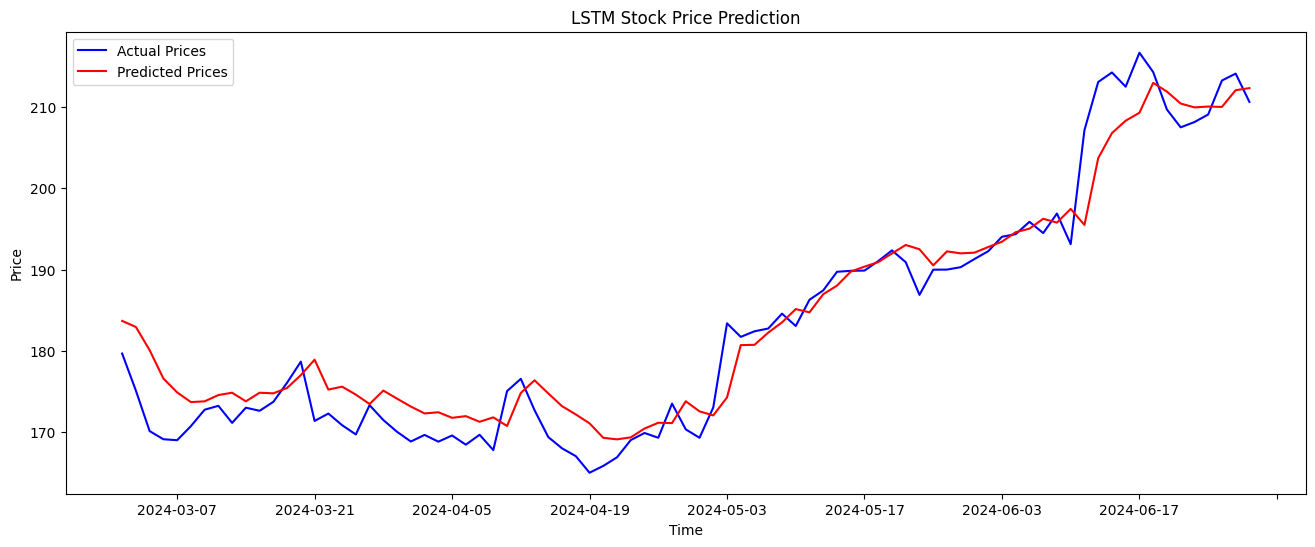

In [10]:
# Predict on test data
predicted_prices = best_model.predict(X_test) # type: ignore
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(y_test)
test_loss = mse(actual_prices, predicted_prices)

print(f"Test Loss: {test_loss}\n")
plt.figure(figsize=(16, 6))
plt.plot(data['Date'][len(data) - len(actual_prices):], actual_prices, color='blue', label='Actual Prices')
plt.plot(predicted_prices, color='red', label='Predicted Prices')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))  # Customize interval to 5 days
plt.title('LSTM Stock Price Prediction for Apple from March 01, 2024 to June 28, 2024')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
